## Silverbox

Silverbox is the name of a nonlinear system identification benchmark, proposed in 2004. Data, baselines and more info can be found at http://nonlinearbenchmark.org/#Silverbox.

State-space formulation of Silverbox's dynamics:

$$\begin{align}
\mu \frac{d^2 x(t)}{dt^2} + \nu \frac{d x(t)}{dt} + \kappa(x(t)) x(t) =&\ u(t) + w(t) \\
\kappa(x(t)) =&\ \alpha + \beta x^2(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
\mu     =&\ \text{mass} \\
\nu     =&\ \text{viscous damping} \\
\kappa(x(t)) =&\ \text{nonlinear spring} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

### Steps to solve

I now take a series of steps to re-write this problem:

#### 1. Assume constant spring coefficient κ

$$ \mu \frac{d^2 x(t)}{dt^2} + \nu \frac{d x(t)}{dt} + κ x(t) = u(t) + w(t)$$

#### 2. Divide by leading coefficient

$$ \frac{d^2 x(t)}{dt^2} + \frac{\nu}{\mu} \frac{d x(t)}{dt} + \frac{κ}{\mu} x(t) = \frac{1}{\mu} u(t) + \frac{1}{\mu} w(t)$$

#### 3. Substitute standard variables

$$ \frac{d^2 x(t)}{dt^2} + 2\zeta \omega_0 \frac{d x(t)}{dt} + \omega_0^2 x(t) - \frac{u(t)}{\mu} = \frac{w(t)}{\mu}$$

where $$\begin{align} 
\zeta =&\ \frac{\nu}{2\sqrt{\mu \kappa}} \\ 
\omega_0 =&\ \sqrt{\frac{\kappa}{\mu}} \, .
\end{align}$$

#### 4. Apply Euler's method to obtain difference equation

-> Forward difference:

$$\begin{align}
\frac{x(t+2h)-2x(t+h)+x(t)}{h^2} + 2\zeta \omega_0 \frac{x(t+h)-x(t)}{h} + \omega_0^2 x(t) - \frac{u(t)}{\mu} =&\ \frac{w(t)}{\mu}
\end{align}$$
Set $h$ to sampling frequency and swap to index time-points:
$$\begin{align}
x_{t+2} + 2(\zeta \omega_0 - 1) x_{t+1} + (1 - 2 \zeta \omega_0 + \omega_0^2) x_{t} - \frac{u_t}{\mu} =&\ \frac{w_t}{\mu} 
\end{align}$$

-> Backward difference:

$$\begin{align}
\frac{x(t)-2x(t-h)+x(t-2h)}{h^2} - 2\zeta \omega_0 \frac{x(t)-x(t-h)}{h} - \omega_0^2 x(t) - \frac{u(t)}{\mu} =&\ \frac{w(t)}{\mu} 
\end{align}$$
Set $h$ to sampling frequency and swap to index time-points:
$$\begin{align}
(1 + 2 \zeta \omega_0 + \omega_0^2)x_t - 2(1 + \zeta \omega_0)x_{t-1} - x_{t-2} - \frac{u_t}{\mu} =&\ \frac{w_t}{\mu} \\
x_t - \frac{2(1 + \zeta \omega_0)}{(1 + 2\zeta \omega_0 + \omega_0^2)}x_{t-1} - \frac{1}{(1 + 2\zeta \omega_0 + \omega_0^2)}x_{t-2} - \frac{u_t}{\mu(1 + 2\zeta \omega_0 + \omega_0^2)} =&\ \frac{w_t}{\mu(1 + 2\zeta \omega_0 + \omega_0^2)}
\end{align}$$
    
Change to shorthand notation:

$$x_t - \theta_1 x_{t-1} - \theta_2 x_{t-2} - \eta u_t = \eta w_t$$

where 
$$\begin{align} 
\theta_1 =&\ \frac{2(1 + \zeta \omega_0)}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\theta_2 =&\ \frac{1}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\eta =&\ \frac{1}{\mu(1 + 2 \zeta \omega_0 + \omega_0^2)}
\end{align}$$

Given three equations and three unknowns, I can recover $\zeta$, $\omega_0$ and $\mu$ from $\theta_1$, $\theta_2$, and $\eta$.

#### 5. Convert to multivariate first-order difference form

Stick to backward difference (matches AR structure)

$$z_t = A(\theta) z_{t-1} + c\eta u_t + c\eta w_t$$

where $z_t = [x_t\ \ x_{t-1}]$, $A(\theta) = [\theta_1 \ \ \theta_2; 1\ \ 0]$, $c = [1\ \ 0]$.

#### 6. Convert to Gaussian probability

$$z_t \sim \mathcal{N}(A(\theta) z_{t-1} + c\eta u_t, cc^{\top} \eta \tau)$$

for $w_t \sim \mathcal{N}(0, \tau)$.

#### 7. Observation likelihood

$$y_t \sim \mathcal{N}(c^{\top} z_t, σ)$$

where $e_t \sim \mathcal{N}(0, \sigma)$.

I will first study a situation with known measurement noise (so $\sigma$ is fixed). That means I need priors for $\theta$, $\eta$, and $\tau$. The variables are all strictly positive, which means they can be modeled by log-normal and gamma distributions:

$$\begin{align}
\log(\theta) \sim&\ \mathcal{N}(m_\theta, W_\theta) \\
\log(\eta) \sim&\ \mathcal{N}(m_\eta, W_\eta) \\
\tau \sim&\ Γ(a_\tau, b_\tau) 
\end{align}$$

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots

viz = false

false

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    # Plots.savefig(p1, "viz/output_signal.png")
end

In [5]:
if viz
    p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
    # Plots.savefig(p2, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [6]:
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

I will use the Nonlinear node to cope with a multivariate log-normal distribution.

In [7]:
# Start graph
graph = FactorGraph()

# Static parameters
@RV lθ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:W_θ, dims=(2,2)))
@RV lη ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Nonlinear function
g(x) = exp.(x)
g_inv(x) = log.(x) # Not used in Nonlinear due to DomainError

# Nonlinear node
@RV θ ~ Nonlinear{Unscented}(lθ; g=g, dims=(2,))
@RV η ~ Nonlinear{Unscented}(lη; g=g, dims=(1,))

# Observation selection variable
c = [1, 0]

# Measurement precision
τ_y = 100.

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:W_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControl(θ, z_t, η, placeholder(:u_t), τ, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot(c, x_t), τ_y, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4113052908646580452 -->
 
 4113052908646580452 
 
 placeholder_a_τ 
 
<!-- 17383053663036181319 -->
 
 17383053663036181319 
 
 placeholder_W_z 
 
<!-- 14039727086162472206 -->
 
 14039727086162472206 
 
 clamp_1 
 
<!-- 6803947934153564721 -->
 
 6803947934153564721 
 
 placeholder_m_θ 
 
<!-- 11716087696198651117 -->
 
 11716087696198651117 
 
 dot 
 dotproduct_1 
 
<!-- 11716087696198651117--14039727086162472206 -->
 
 11716087696198651117--14039727086162472206 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 116512576920582280 -->
 
 116512576920582280 
 
 ARC 
 x_t 
 
<!-- 11716087696198651117--116512576920582280 -->
 
 11716087696198651117--116512576920582280 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 16777773222480716086 -->
 
 16777773222480716086 
 
 placeholder_m_z 
 
<!-- 12898333946110376941 -->
 
 12898333946110376941 
 
 𝒩 
 z_t 
 
<!-- 12898333946110376941--17383053663036181319 -->
 
 12898333946110376941--17383053663036181319 
 
 W_z 
 1 out 
 3 w 
 
<!-- 12898333946110376941--16777773222480716086 -->
 
 12898333946110376941--16777773222480716086 
 
 m_z 
 1 out 
 2 m 
 
<!-- 16717664087875372841 -->
 
 16717664087875372841 
 
 placeholder_w_η 
 
<!-- 116512576920582280--12898333946110376941 -->
 
 116512576920582280--12898333946110376941 
 
 z_t 
 1 out 
 2 x 
 
<!-- 326050009805442448 -->
 
 326050009805442448 
 
 Nonlinear{Unscented} 
 nonlinear_2 
 
<!-- 116512576920582280--326050009805442448 -->
 
 116512576920582280--326050009805442448 
 
 η 
 1 out 
 4 η 
 
<!-- 10092719264159644705 -->
 
 10092719264159644705 
 
 Gam 
 gamma_1 
 
<!-- 116512576920582280--10092719264159644705 -->
 
 116512576920582280--10092719264159644705 
 
 τ 
 1 out 
 6 γ 
 
<!-- 13543746832854576743 -->
 
 13543746832854576743 
 
 Nonlinear{Unscented} 
 nonlinear_1 
 
<!-- 116512576920582280--13543746832854576743 -->
 
 116512576920582280--13543746832854576743 
 
 θ 
 1 out 
 3 θ 
 
<!-- 16391338683066488049 -->
 
 16391338683066488049 
 
 placeholder_u_t 
 
<!-- 116512576920582280--16391338683066488049 -->
 
 116512576920582280--16391338683066488049 
 
 u_t 
 1 out 
 5 u 
 
<!-- 13914650680524590286 -->
 
 13914650680524590286 
 
 placeholder_b_τ 
 
<!-- 3919306903775846682 -->
 
 3919306903775846682 
 
 placeholder_W_θ 
 
<!-- 6362211887579529945 -->
 
 6362211887579529945 
 
 placeholder_y_t 
 
<!-- 16499747394168573657 -->
 
 16499747394168573657 
 
 𝒩 
 y_t 
 
<!-- 6362211887579529945--16499747394168573657 -->
 
 6362211887579529945--16499747394168573657 
 
 y_t 
 1 out 
 1 out 
 
<!-- 8700652160971567874 -->
 
 8700652160971567874 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 326050009805442448--8700652160971567874 -->
 
 326050009805442448--8700652160971567874 
 
 lη 
 1 out 
 2 in1 
 
<!-- 10092719264159644705--4113052908646580452 -->
 
 10092719264159644705--4113052908646580452 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 10092719264159644705--13914650680524590286 -->
 
 10092719264159644705--13914650680524590286 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 8700652160971567874--16717664087875372841 -->
 
 8700652160971567874--16717664087875372841 
 
 w_η 
 1 out 
 3 w 
 
<!-- 9420307270373763209 -->
 
 9420307270373763209 
 
 placeholder_m_η 
 
<!-- 8700652160971567874--9420307270373763209 -->
 
 8700652160971567874--9420307270373763209 
 
 m_η 
 1 out 
 2 m 
 
<!-- 9507352267154143231 -->
 
 9507352267154143231 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 13543746832854576743--9507352267154143231 -->
 
 13543746832854576743--9507352267154143231 
 
 lθ 
 1 out 
 2 in1 
 
<!-- 16499747394168573657--11716087696198651117 -->
 
 16499747394168573657--11716087696198651117 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 12139090867174222226 -->
 
 12139090867174222226 
 
 clamp_2 
 
<!-- 16499747394168573657--12139090867174222226 -->
 
 16499747394168

In [8]:
# Infer an algorithm
q = PosteriorFactorization(z_t, x_t, θ, lθ, η, lη, τ, ids=[:z, :x, :θ, :lθ, :η, :lη, :τ])
algo = variationalAlgorithm(q, free_energy=false)
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
# println(source_code)

In [9]:
# Looking at only the first few timepoints
# T = 100
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_η = (zeros(1,T+1), 0.1 *ones(1,T+1))
params_τ = (0.1*ones(1,T+1), 0.01*ones(1,T+1))

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:lθ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:lη] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0., 0.], w=[1. 0.; 0. 1.])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=0., w=1.)
    marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=params_τ[1][1,t], b=params_τ[2][1,t])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :m_θ => params_θ[1][:,t],
                :m_η => params_η[1][1,t],
                :W_z => params_x[2][:,:,t],
                :W_θ => params_θ[2][:,:,t],
                :w_η => params_η[2][1,t],
                :a_τ => params_τ[1][1,t],
                :b_τ => params_τ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepτ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_θ[1][:,t+1] = unsafeMean(marginals[:lθ])
    params_η[1][1,t+1] = unsafeMean(marginals[:lη])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_θ[2][:,:,t+1] = marginals[:lθ].params[:w]
    params_η[2][1,t+1] = marginals[:lη].params[:w]
    params_τ[1][1,t+1] = marginals[:τ].params[:a]
    params_τ[2][1,t+1] = marginals[:τ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:03:146:40


### Visualize results

In [10]:
viz = true

true

In [11]:
# Extract mean of state marginals
estimated_states = params_x[1][1,2:end]

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    Plots.plot!(1:n:T, estimated_states[1:n:T], color="red", linewidth=1, label="estimated")
    # Plots.savefig(p1, "viz/estimated_states01.png")
end

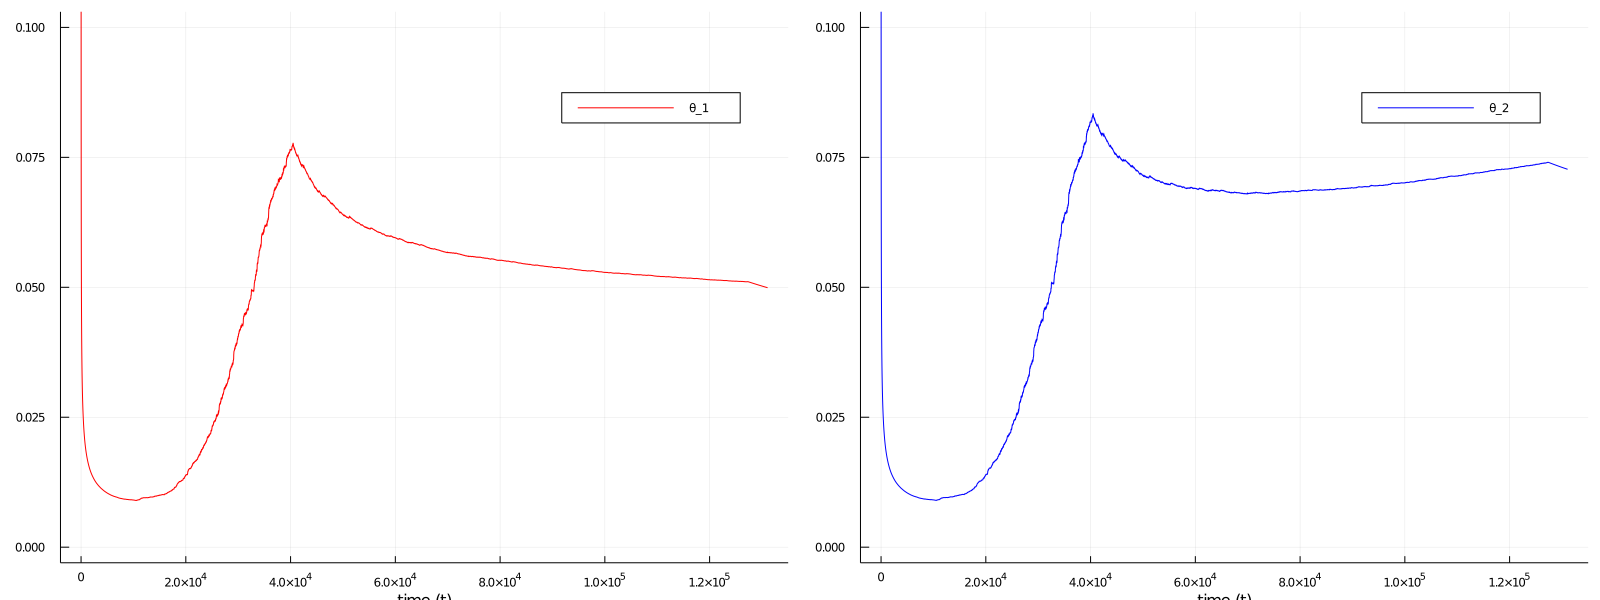

In [12]:
# Extract mean of coefficient marginals
estimated_coeffs = exp.(params_θ[1][:,2:end])

if viz
    # Plot both coefficients next to each other
    p2a = Plots.plot(1:n:T, estimated_coeffs[1,1:n:T], color="red", label="θ_1", xlabel="time (t)", ylim=[0., 0.1])
    p2b = Plots.plot(1:n:T, estimated_coeffs[2,1:n:T], color="blue", label="θ_2", xlabel="time (t)", ylim=[0., 0.1])
    plot(p2a, p2b, size=(1600,600))
    # Plots.savefig(p1, "viz/estimated_coeffs1.png")
end

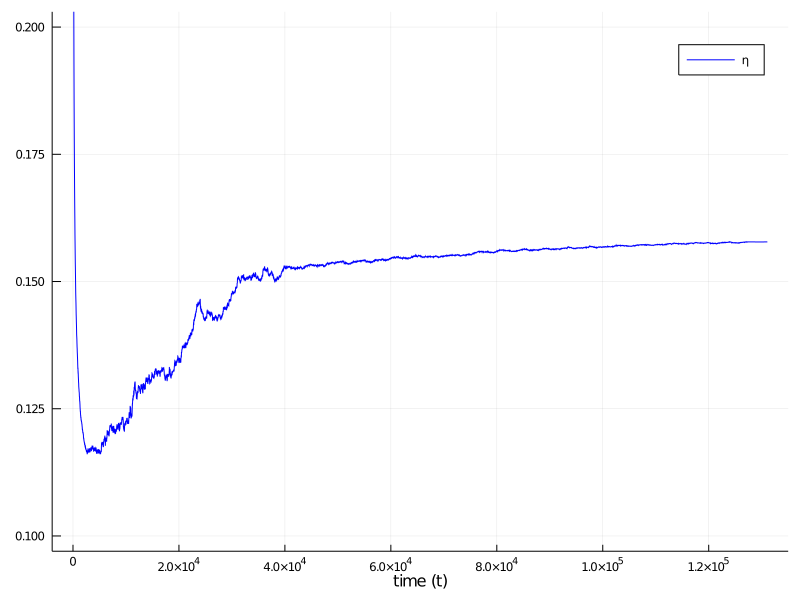

In [13]:
# Extract mean of control coefficient marginals
estimated_ccoeff = exp.(params_η[1][1,2:end])

if viz
    # Plot both coefficients next to each other
    Plots.plot(1:n:T, estimated_ccoeff[1:n:T], color="blue", label="η", xlabel="time (t)", size=(800,600), ylim=[0.1, 0.2])
    # Plots.savefig(p1, "viz/estimated_ccoeff.png")
end

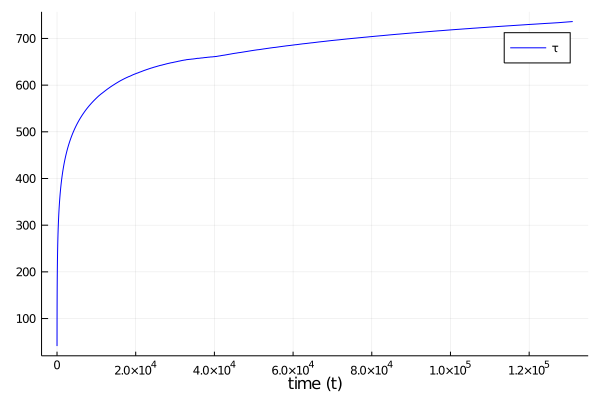

In [14]:
# Extract mean of process precision marginals
estimated_pnoise = params_τ[1][1,2:end] ./ params_τ[2][1,2:end]

if viz
    # Plot both coefficients next to each other
    Plots.plot(1:n:T, estimated_pnoise[1:n:T], color="blue", label="τ", xlabel="time (t)")
    # Plots.savefig(p1, "viz/estimated_pnoise.png")
end

## Solving nonlinear system of equations

We currently have estimates for $\theta_1$, $\theta_2$, and $\eta$. But we want to know the original coefficients, $\mu$, $\nu$ and $\kappa$, which actually have a physical meaning. To obtain estimates for those, we first have to solve the following nonlinear system of equations:

$$\begin{align} 
\hat{\theta_1} =&\ \frac{2(1 + \zeta \omega_0)}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\hat{\theta_2} =&\ \frac{1}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\hat{\eta} =&\ \frac{1}{\mu(1 + 2 \zeta \omega_0 + \omega_0^2)}
\end{align}$$

--> Implementation using NLsolve.jl

In [15]:
using NLsolve

In [16]:
# Current estimates of parameters
global estimates = [estimated_coeffs[1,end], estimated_coeffs[2,end], estimated_ccoeff[1,end]]

3-element Array{Float64,1}:
 0.04991917688229905
 0.07270319256186324
 0.960671961927855

In [17]:
# Define nonlinear system of equations
function f1!(F, x)
    F[1] = (2*(1 + x[1]*x[2]))/(1 + 2*x[1]*x[2] + x[2]^2)  - estimates[1]
    F[2] = 1/(1 + 2*x[1]*x[2] + x[2]^2) - estimates[2]
    F[3] = 1/(x[3]*(1 + 2*x[1]*x[2] + x[2]^2)) - estimates[3]
end

# Jacobian of each equation
function j1!(J, x)
    
    # F[1]
    J[1, 1] = (2*x[2]*(1 + 2*x[1]*x[2] + x[2]^2) - 2*(1 + x[1]*x[2])*2*x[2]) / (1 + 2*x[1]*x[2] + x[2]^2)^2
    J[1, 2] = (2*x[1]*(1 + 2*x[1]*x[2] + x[2]^2) - 2*(1 + x[1]*x[2])*(2*x[1] + 2*x[2])) / (1 + 2*x[1]*x[2] + x[2]^2)^2
    J[1, 3] = 0.
    
    # F[2]
    J[2, 1] = (-2*x[2]) / (1 + 2*x[1]*x[2] + x[2]^2)^2
    J[2, 2] = (-(2*x[1] + 2*x[2])) / (1 + 2*x[1]*x[2] + x[2]^2)^2
    J[2, 3] = 0.
    
    # F[3]
    J[3, 1] = (-2*x[3]*x[2]) / (x[3]*(1 + 2*x[1]*x[2] + x[2]^2))^2
    J[3, 2] = (-(2*x[3]*x[2] + 2*x[3]*x[2])) / (x[3]*(1 + 2*x[1]*x[2] + x[2]^2))^2
    J[3, 3] = (-(1 + 2*x[1]*x[2] + x[2]^2)) / (x[3]*(1 + 2*x[1]*x[2] + x[2]^2))^2
    
end

# Call solver
# x_solved = nlsolve(f1!, j1!, [1. 1. 1.])
x_solved = nlsolve(f1!, [1. 1. 1.], autodiff=:forward)

# Extract new estimates
global ζ, ω0, μ = x_solved.zero

1×3 Array{Float64,2}:
 -0.175084  3.75073  0.0756795

We now have estimates for $\zeta$, $\omega_0$ and $\mu$. But we still need the friction $\nu$ and spring $\kappa$ coefficients. These can be obtained by solving another nonlinear system of equations:

$$\begin{align} 
\zeta =&\ \frac{\nu}{2\sqrt{\mu \kappa}} \\ 
\omega_0 =&\ \sqrt{\frac{\kappa}{\mu}} \, .
\end{align}$$

In [18]:
# Define nonlinear system of equations
function f2!(F, x)
    F[1] = x[1] / (2*sqrt(μ * x[2])) - ζ
    F[2] = sqrt(x[2] / μ) - ω0
end

# Jacobian of each equation
function j2!(J, x)
    
    # F[1]
    J[1, 1] = 1 / (2*sqrt(μ*x[2]))
    J[1, 2] = (-x[1]*μ) / (4*(μ*x[2])^(3/2))
    
    # F[2]
    J[2, 1] = 0.
    J[2, 2] = (sqrt(x[2]/μ)) / (2*x[2])
    
end

# Call solver
# x_solved = nlsolve(f2!, j2!, [1. 1.])
x_solved = nlsolve(f2!, [1. 1.], autodiff=:forward)

# Extract new estimates
global ν, κ = x_solved.zero

1×2 Array{Float64,2}:
 -0.0993963  1.06465

So, in total we estimate the dynamical parameters as follows:

In [19]:
println("μ = " *string(μ))
println("ν = " *string(ν))
println("κ = " *string(κ))

μ = 0.07567951958956326
ν = -0.09939626847025404
κ = 1.0646548001953235
